In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy.special import expit
from scipy import interpolate
from scipy import integrate
from collections import Counter
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings('default')

In [3]:
def interpolate_roc_fun(fpr, tpr, n_grid):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    roc_approx = interpolate.interp1d(x=fpr, y=tpr)
    x_new = np.linspace(0, 1, num=n_grid)
    y_new = roc_approx(x_new)
    return x_new, y_new

In [4]:
def compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1, n_grid=10000, lb=0, ub=1, limit=1000):
    """https://github.com/VaibhavKaushik3220/abroca/blob/main/abroca/compute_abroca.py"""
    # Compute the value of the abroca statistic.
    
    # compare minority to majority class; accumulate absolute difference btw ROC curves to slicing statistic
    majority_roc_x, majority_roc_y = interpolate_roc_fun(fpr_0, tpr_0, n_grid)
    minority_roc_x, minority_roc_y = interpolate_roc_fun(fpr_1, tpr_1, n_grid)

    # use function approximation to compute slice statistic via piecewise linear function
    assert list(majority_roc_x) == list(minority_roc_x), "Majority and minority FPR are different"
    f1 = interpolate.interp1d(x=majority_roc_x, y=(majority_roc_y - minority_roc_y))
    f2 = lambda x, acc: abs(f1(x))
    slice, _ = integrate.quad(f2, lb, ub, limit)

    return slice

### Simulate Data

In [5]:
np.linalg.norm(np.array([5,5])-np.array([10,10]), ord=2)

7.0710678118654755

In [52]:
def simulate(sigma_scale_factor=1, subgroup_n=[10000, 10000], mu_0=[0,0], mu_1=[0,0], 
             sigma_0=[1,1], sigma_1=[1,1], rounding_thresh=[.5,.5], eta_sd=[0.1, 0.1], gwfm_diff=None, 
             eta_mean=[0,0]):
    
    if gwfm_diff is not None:
        mu_1[0] = mu_0[0] - np.sqrt(gwfm_diff**2/2)
        mu_1[1] = mu_0[1] - np.sqrt(gwfm_diff**2/2)
    
    mu = [mu_0, mu_1]
    
    sigma = [np.diag(sigma_0),np.diag(np.dot(sigma_1, sigma_scale_factor))]

    X = np.array([])
    y = np.array([])

    for i in range(len(subgroup_n)):
        ax = np.random.multivariate_normal(mu[i],sigma[i],size=subgroup_n[i])
        X = np.append(X.reshape((-1,2)),ax,axis=0)
        aeta = np.random.normal(eta_mean[i],eta_sd[i])
        theta = np.ones((subgroup_n[i], 2))
        ap = expit(np.sum(theta*ax, axis=1) + aeta)
        ay = (np.random.uniform(size=len(ap)) <= ap)
        
    #look at ay to see group imbalance
        y = np.append(y, ay, axis=0)
        print(f'*{Counter(ay)}')
    return X, y
    

*Counter({False: 5183, True: 4817})
*Counter({False: 5228, True: 4772})


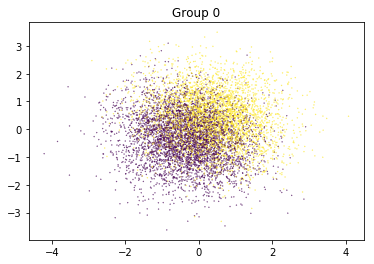

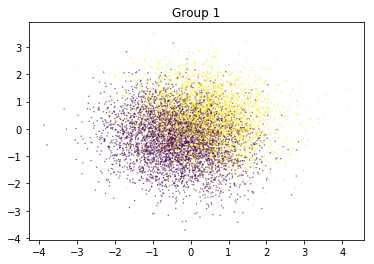

In [19]:
# np.random.seed(12)
n= [10000, 10000]
X, y = simulate(sigma_scale_factor=1, subgroup_n=n, sigma_0=[1,1], sigma_1=[1,1], 
                eta_sd=0.1)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)


plt.scatter(X_train_0[:,0], X_train_0[:,1], c=y_train_0, s=0.1)
plt.title('Group 0')
plt.show()
plt.scatter(X_train_1[:,0], X_train_1[:,1], c=y_train_1, s=0.1)
plt.title('Group 1')
plt.show()

### Regression and Main Plot

*Counter({False: 46, True: 4})
*Counter({False: 25, True: 25})
*Counter({False: 50})
*Counter({True: 25, False: 25})
*Counter({False: 37, True: 13})
*Counter({True: 27, False: 23})


/Users/nswinger/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/nswinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]
/Users/nswinger/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/nswinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


*Counter({True: 48, False: 2})
*Counter({False: 28, True: 22})
*Counter({False: 41, True: 9})
*Counter({True: 25, False: 25})


/Users/nswinger/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/nswinger/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/nswinger/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/nswinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


*Counter({True: 484, False: 16})
*Counter({False: 270, True: 230})
*Counter({False: 496, True: 4})
*Counter({True: 257, False: 243})
*Counter({True: 456, False: 44})
*Counter({True: 262, False: 238})


/Users/nswinger/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/nswinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]


*Counter({True: 490, False: 10})
*Counter({False: 264, True: 236})
*Counter({True: 369, False: 131})
*Counter({True: 261, False: 239})
*Counter({False: 3442, True: 1558})
*Counter({True: 2584, False: 2416})
*Counter({False: 4788, True: 212})
*Counter({False: 2547, True: 2453})
*Counter({False: 2965, True: 2035})
*Counter({True: 2531, False: 2469})
*Counter({False: 4398, True: 602})
*Counter({False: 2518, True: 2482})
*Counter({True: 3108, False: 1892})
*Counter({True: 2505, False: 2495})
*Counter({False: 49124, True: 876})
*Counter({True: 25645, False: 24355})
*Counter({False: 43494, True: 6506})
*Counter({False: 25629, True: 24371})
*Counter({True: 47631, False: 2369})
*Counter({True: 25139, False: 24861})
*Counter({True: 46191, False: 3809})
*Counter({False: 25056, True: 24944})
*Counter({False: 48187, True: 1813})
*Counter({False: 25199, True: 24801})
average auc score: 0.6950200761423351


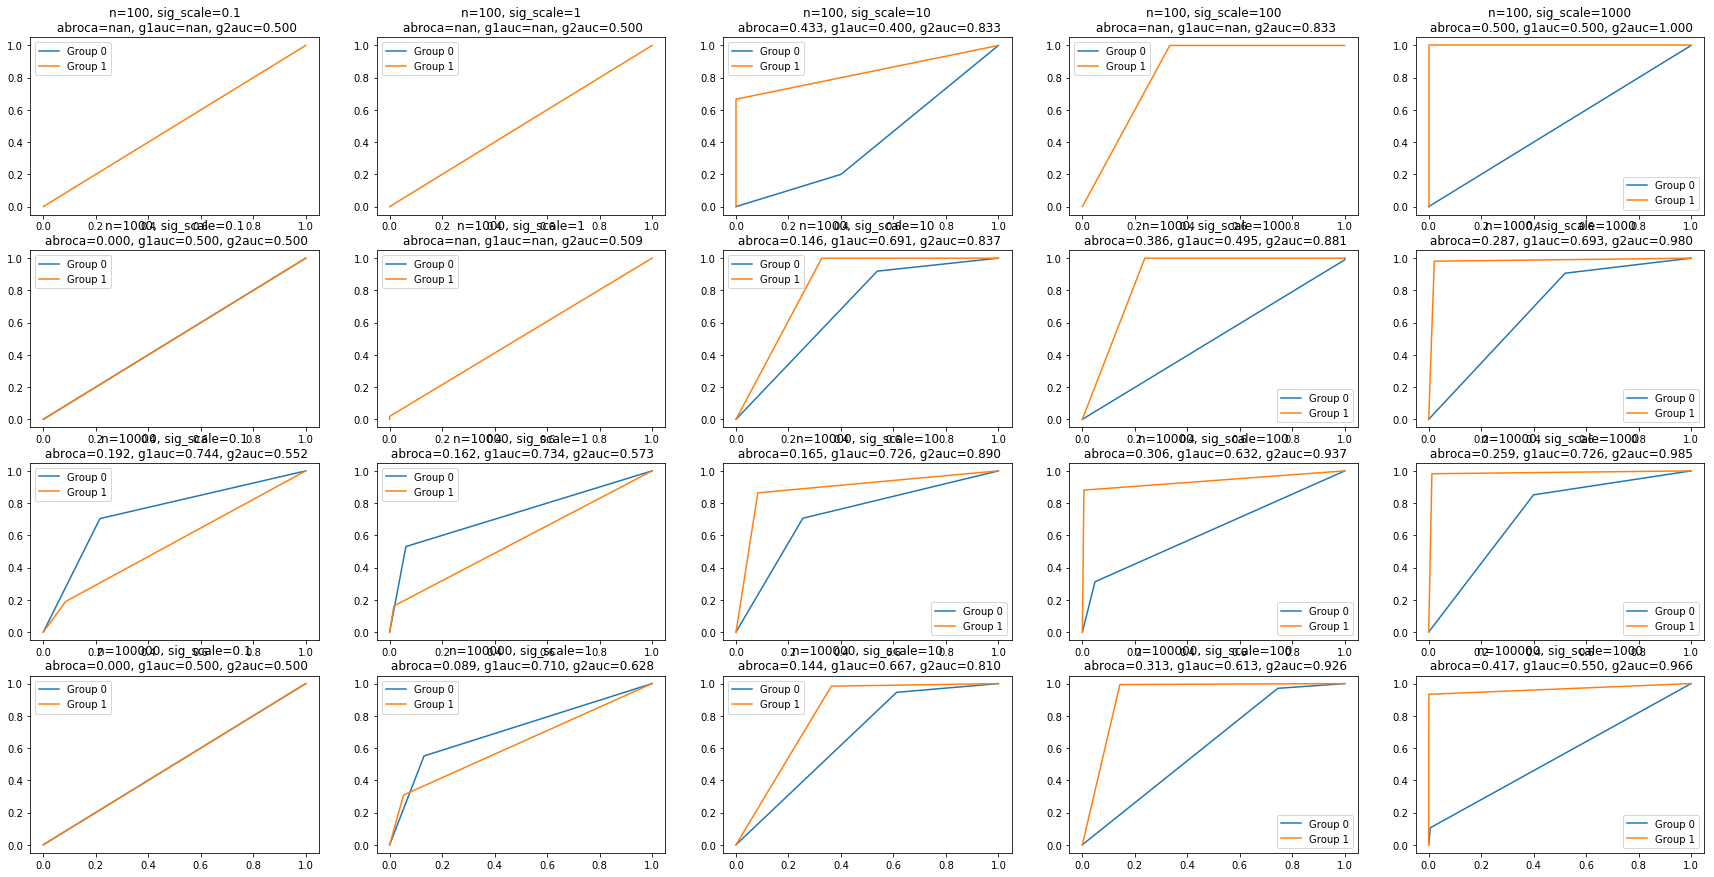

In [55]:
np.random.seed(13)
ns = [10**i for i in range(2,6)]
sig_scale_factors = [10**i for i in range(-1,4)]
fig, axs = plt.subplots(len(ns), len(sig_scale_factors), figsize=(30,15))

avg_auc = []
for row, a_n in enumerate(ns):
    for col, a_s in enumerate(sig_scale_factors):
        
        n = [a_n//2, a_n//2]
        X, y = simulate(sigma_scale_factor=a_s, subgroup_n=n, sigma_0=[1,1], sigma_1=[1,1], eta_sd=[2.5,0.05])

        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)


        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)
        
        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
        
        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)
        avg_auc += [g1auc, g2auc]
        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        
        axs[row, col].plot(fpr_0, tpr_0, label='Group 0')
        axs[row, col].plot(fpr_1, tpr_1, label='Group 1')
        axs[row, col].legend()
        axs[row, col].set_title(f"n={sum(n)}, sig_scale={a_s}\n abroca={abroca:.3f}, g1auc={g1auc:.3f}, g2auc={g2auc:.3f}")        

print(f"average auc score: {np.mean([_ for _ in avg_auc if not math.isnan(_)])}")

### Observation Noise VS ABROCA

/Users/nswinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


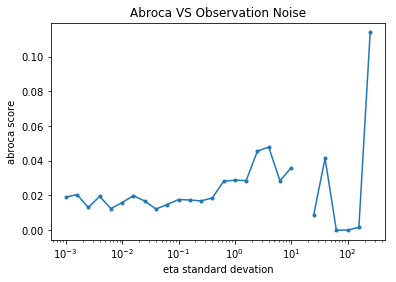

In [40]:
eta_sds = [10**i for i in np.arange(-3,3,0.2)]
es_plot = []
np.random.seed(11)
avg_abrocas = None
for i in range(10):
    abrocas = [np.nan for _ in range(len(eta_sds))]
    for j, e in enumerate(eta_sds):
#         print(f'e={e}')
        n = [5000, 5000]
        X, y = simulate(subgroup_n=n, eta_sd=e)

        X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)

        X_train = np.append(X_train_0, X_train_1, axis=0)
        y_train = np.append(y_train_0, y_train_1, axis=0)
    #     print(f'X_train: {len(X_train)}, y_train: {len(y_train)}')
    #     print(f'X_test_0: {len(X_test_0)}, y_test_0: {len(y_test_0)}')
    #     print(f'X_test_1: {len(X_test_1)}, y_test_1: {len(y_test_1)}')

        if len(set(y_train)) == 1:
            continue

        #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
        #regressor = LogisticRegression()
        regressor = LogisticRegressionCV(cv=5, random_state=0)
        regressor.fit(X_train, y_train)

        y_pred_0 = regressor.predict(X_test_0)
        y_pred_1 = regressor.predict(X_test_1)

        if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
            continue
        
        fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
        fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

        g1auc = auc(fpr_0, tpr_0)
        g2auc = auc(fpr_1, tpr_1)
        abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
        abrocas[j] = abroca
#         print()
    if avg_abrocas is None:
        avg_abrocas = np.array(abrocas).reshape((-1,1))
    else:
        avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1,1)), axis=1)

avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()
plt.xscale('log')
plt.yscale('linear')
plt.plot(eta_sds,avg_abrocas,marker='.')
plt.xlabel('eta standard devation')
plt.ylabel('abroca score')
plt.title('Abroca VS Observation Noise')

if len(eta_sds) < 10:
    for i, txt in enumerate(eta_sds):
        if i == 0:
            txt = f'e={txt}'
        plt.annotate(txt, (eta_sds[i], avg_abrocas[i]))
plt.show()

### Group Imbalance VS ABROCA

e=-5.0
*Counter({True: 5118, False: 4882})
*Counter({False: 6375, True: 3625})

e=-4.5
*Counter({False: 5293, True: 4707})
*Counter({False: 6272, True: 3728})

e=-4.0
*Counter({False: 5161, True: 4839})
*Counter({False: 6115, True: 3885})

e=-3.5
*Counter({False: 5323, True: 4677})
*Counter({False: 5899, True: 4101})

e=-3.0
*Counter({True: 5100, False: 4900})
*Counter({False: 5940, True: 4060})

e=-2.5
*Counter({True: 5396, False: 4604})
*Counter({False: 5674, True: 4326})

e=-2.0
*Counter({True: 5190, False: 4810})
*Counter({False: 5447, True: 4553})

e=-1.5
*Counter({True: 5217, False: 4783})
*Counter({False: 5364, True: 4636})

e=-1.0
*Counter({True: 5177, False: 4823})
*Counter({False: 5241, True: 4759})

e=-0.5
*Counter({True: 5137, False: 4863})
*Counter({False: 5159, True: 4841})

e=0.0
*Counter({True: 5264, False: 4736})
*Counter({True: 5001, False: 4999})

e=0.5
*Counter({False: 5041, True: 4959})
*Counter({True: 5151, False: 4849})

e=1.0
*Counter({True: 5094, False: 4906})


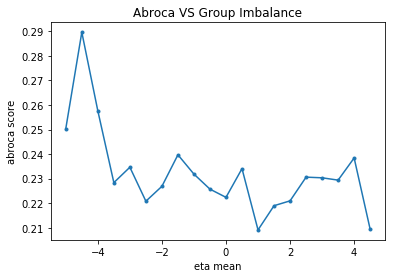

In [58]:
eta_means = np.arange(-5,5,0.5)
es_plot = []
np.random.seed(8)
abrocas = []
aucs = []
for e in eta_means:
    print(f'e={e}')
    n = [10000, 10000]
    X, y = simulate(subgroup_n=n, eta_mean=[0,e], sigma_scale_factor=100)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)
    
    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
#     print(f'X_train: {len(X_train)}, y_train: {len(y_train)}')
#     print(f'X_test_0: {len(X_test_0)}, y_test_0: {len(y_test_0)}')
#     print(f'X_test_1: {len(X_test_1)}, y_test_1: {len(y_test_1)}')
    
    if len(set(y_train)) == 1:
        continue
    
    #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
    regressor = LogisticRegressionCV(cv=5, random_state=0)
    regressor.fit(X_train, y_train)

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        continue
        
    es_plot.append(e)
    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g1auc = auc(fpr_0, tpr_0)
    g2auc = auc(fpr_1, tpr_1)
    aucs.append(g1auc)
    abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
    abrocas.append(abroca)
    print()
print(np.mean(aucs))
plt.plot(es_plot,abrocas,marker='.')
plt.xlabel('eta mean')
plt.ylabel('abroca score')
plt.title('Abroca VS Group Imbalance')

if len(es_plot) < 10:
    for i, txt in enumerate(es_plot):
        if i == 0:
            txt = f'e={txt}'
        plt.annotate(txt, (es_plot[i], abrocas[i]))
plt.show()

### Difference in groupwise feature means VS ABROCA

gwfm diff=0.0

gwfm diff=0.5

gwfm diff=1.0

gwfm diff=1.5

gwfm diff=2.0

gwfm diff=2.5

gwfm diff=3.0

gwfm diff=3.5

gwfm diff=4.0

gwfm diff=4.5

gwfm diff=5.0

gwfm diff=5.5

gwfm diff=6.0

gwfm diff=6.5

gwfm diff=7.0

gwfm diff=7.5
gwfm diff=8.0
gwfm diff=8.5
gwfm diff=9.0
gwfm diff=9.5


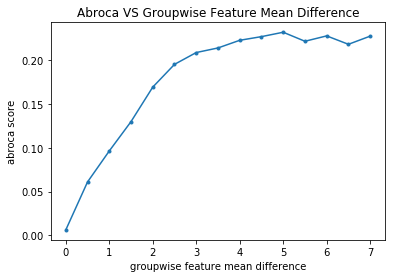

In [42]:
gwfms = np.arange(0,10,0.5)
gwfms_plot = []
np.random.seed(11)
abrocas = []
for g in gwfms:
    print(f'gwfm diff={g}')
    n = [50000, 50000]
    X, y = simulate(subgroup_n=n, mu_0=[0,0], mu_1=[0,0], gwfm_diff=g)

    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n[0]], y[:n[0]], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n[0]:], y[n[0]:], test_size=0.2, random_state=0)
    
    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)
#     print(f'X_train: {len(X_train)}, y_train: {len(y_train)}')
#     print(f'X_test_0: {len(X_test_0)}, y_test_0: {len(y_test_0)}')
#     print(f'X_test_1: {len(X_test_1)}, y_test_1: {len(y_test_1)}')
    
    if len(set(y_train)) == 1:
        continue
    
    #regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    #regressor = LogisticRegression() #find regularized logisticRegression - cv logistic regression
    regressor = LogisticRegressionCV(cv=5, random_state=0)
    regressor.fit(X_train, y_train)

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        continue
        
    gwfms_plot.append(g)
    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g1auc = auc(fpr_0, tpr_0)
    g2auc = auc(fpr_1, tpr_1)
    abroca = compute_abroca(fpr_0,tpr_0,fpr_1,tpr_1)
    abrocas.append(abroca)
    print()
    
plt.plot(gwfms_plot,abrocas,marker='.')
plt.xlabel('groupwise feature mean difference')
plt.ylabel('abroca score')
plt.title('Abroca VS Groupwise Feature Mean Difference')

if len(gwfms_plot) < 10:
    for i, txt in enumerate(gwfms_plot):
        if i == 0:
            txt = f'diff={txt}'
        plt.annotate(txt, (gwfms_plot[i], abrocas[i]))
plt.show()